In [74]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *



In [75]:
outlier_czs = [34105, 34113, 34112, 34106]

def subset_and_rename_A(df):
    df = df[['aum', 'frac_traveltime_lt15', 'gini', 'rel_tot',
             'cs_fam_wkidsinglemom', 'taxrate', 'frac_worked1416',
             'cs_born_foreign', 'region']]
    df.columns = ['aum', 'travel_lt15', 'gini', 
                  'rel_tot', 'single_mom', 'taxrate', 
                  'worked_14', 'foreign', 'region'] 
    return df

regions = (
    pd.read_csv('data/census_regions.csv',
                header=0, names=['state', 'stateabbrv', 'region', 'div'])
    .drop(columns=['div'])
)

cz_df = (pd.read_csv('data/mobility.csv')
         .query('not aum.isnull()', engine='python')
         .query('cz not in @outlier_czs')
         .merge(regions, on='stateabbrv')
         .pipe(subset_and_rename_A)
        )


(sec:linear_case)=
# Example: Where is the Land of Opportunity?

The US is nicknamed "the land of opportunity" because people believe that in the US
even those with few resources can end up wealthy---economists call this 
notion "economic mobility". 
In one study, economist Raj Chetty and colleagues did a [large-scale data analysis on 
economic mobility in the US](https://doi.org/10.1093/qje/qju022).
His basic question was whether the US is a land of opportunity.
To answer this somewhat vague question, Chetty needed a way to measure economic mobility.

Chetty had access to 2011-12 federal income tax records for everyone born in the US between 1980-82, and their parents tax records filed in their birth year. They matched the 30-year olds to their parents by finding the parents' 1980-82 tax records that listed them as dependents. In total, his dataset had about 10 million people.
To measure economic mobility, Chetty grouped people born in a particular geographic region whose parents' income was in the 25th income percentile in 1980-82. He then found the group's average income percentile in 2011. Chetty calls this average *absolute upward mobility* (AUM).
If a region's AUM is 25, then people born into the 25th percentile generally stay in the 25th percentile---they remain where their parents were when they born.
High AUM values mean that the region has more upward mobility.
Those born into the 25 income percentile in these regions generally wind up in a higher income bracket than their parents.
For reference, the US average AUM is about 41 at the time of this writing.
Chetty calculated the AUM for regions called commuting zones (CZ), which are roughly on the 
same scale as counties. 

While the granularity of the original data is an individual, the data Chetty analyzed has a granularity at the CZ level. Income records can't be publicly available because of privacy,
but the AUM for a commuting zone can be made available. However, even with the granularity of a commuting zone, not all commuting zones are included in the data set because with 40 features in the data, it might be possible to identify individuals in small CZs. This limitation points to a potential coverage bias. Measurement bias is another potential problem. For example, children born into the 25th income percentile who become extremely wealthy may not file income tax. 

We also point out the limitations of working with data that are regional averages, rather than individual measurements. The relationships found between features are often more highly correlated at the aggregate level than at the individual level. This phenomenon is called *ecological regression*, and interpretations of findings from aggregated data need to be made with care. 

Chetty had a hunch that some places in the US have higher economic mobility than others.
His analysis found this to be true.
He found that some cities, such as San Jose, Washington DC, and Seattle, have higher
mobility than others, such as Charlotte, Milwaukee, and Atlanta.
This means that, for example, people move from low to high income brackets in San Jose 
at a higher rate compared to Charlotte.
Chetty used linear models to find social and economic
factors like segregation, income inequality, and local school systems 
are related to economic mobility.

In this analysis, our outcome variable is the AUM for a commuting zone, since we are 
interested in finding features that correlate with AUM.
There are many possible such features in Chetty's data, but
we first investigate one in particular: the fraction of people in a CZ who have a 15-minute or shorter commute to work.

## Explaining Upward Mobility using Commute Time

We begin our investigation by loading the data into a data frame called `cz_df`:

In [76]:
cz_df

,aum,travel_lt15,gini,rel_tot,...,taxrate,worked_14,foreign,region
0,38.39,0.33,0.47,0.51,...,0.02,3.75e-03,1.18e-02,South
1,37.78,0.28,0.43,0.54,...,0.02,4.78e-03,2.31e-02,South
2,39.05,0.36,0.44,0.67,...,0.01,2.89e-03,7.08e-03,South
...,...,...,...,...,...,...,...,...,...
702,44.12,0.42,0.42,0.29,...,0.02,4.82e-03,9.85e-02,West
703,41.41,0.49,0.41,0.26,...,0.01,4.39e-03,4.33e-02,West
704,43.20,0.24,0.42,0.32,...,0.02,3.67e-03,1.13e-01,West


Each row represents one commuting zone.
The column `aum` has the average AUM for people born in the commuting zone in 1980-82 to parents in the 25th income percentile.
There are many columns in this data frame, but for now we focus
on the fraction of people in a CZ that have a 15 minute or shorter commute time, 
which is called `travel_lt15`.
We plot AUM against this fraction to look at the relationship between the two variables:

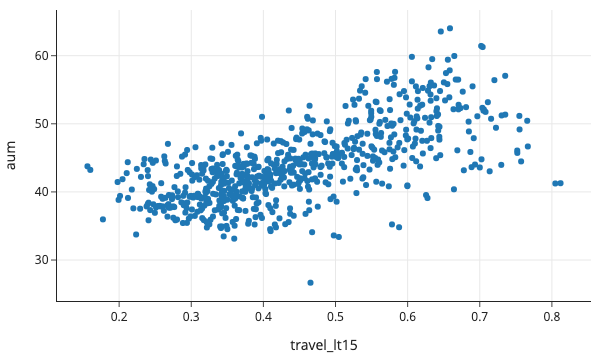

In [77]:
px.scatter(cz_df, x='travel_lt15', y='aum', width=350, height=250)

The scatter plot shows a rough linear association between AUM and commute time. 
Indeed, we find the correlation to be quite strong:

In [78]:
cz_df[['aum', 'travel_lt15']].corr()

,aum,travel_lt15
aum,1.00,0.68
travel_lt15,0.68,1.00


Let's fit a simple linear model, to explain AUM with commute time:

In [79]:
from sklearn.linear_model import LinearRegression

y = cz_df['aum']
X = cz_df[['travel_lt15']]

model_ct = LinearRegression().fit(X, y)

The coefficients from the MSE minimization are:

In [81]:
print(f"Intercept: {model_ct.intercept_:.1f}")
print(f"    Slope: {model_ct.coef_[0]:.1f}")

Intercept: 31.3
    Slope: 28.7


Interestingly, an increase in upward mobility of a CZ is associated with an increase in the fraction of people with a short commute time. 

We can compare the SD of the AUM measurements to the SD of the residuals. This comparison gives us a sense of how useful the model is in explaining the AUM:

In [83]:
prediction = model_ct.predict(X)
error = y - prediction

print(f"SD(errors): {np.std(error):.2f}")
print(f"   SD(AUM): {np.std(cz_df['aum']):.2f}")

SD(errors): 4.14
   SD(AUM): 5.61


The size of the errors about the regression line have decreased from the constant model by about 25%. 

Next, we examine the residuals for lack of fit since it can be easier to see potential problems with the fit in a residual plot:

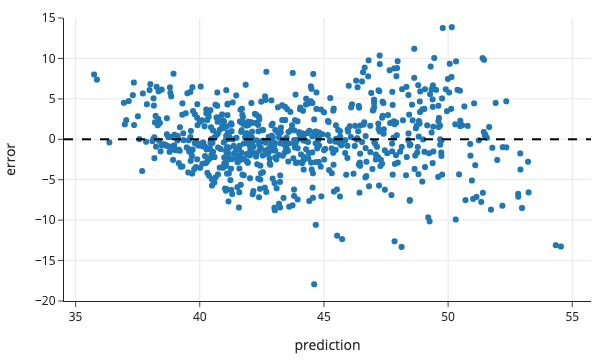

In [84]:
fig = px.scatter(x=prediction, y=error,
                 labels=dict(x='prediction', y='error'),
                 width=350, height=250)

fig.add_hline(0, line_width=2, line_dash='dash', opacity=1)
fig.update_yaxes(range=[-20, 15])

fig.show()

It appears that the errors grow with AUM. We might try a transformation of the response variable, or fitting a model that is quadratic in the commute time fraction. We consider transformations and polynomials in the next section. First we see whether including additional variables offers a more accurate prediction of AUM.  

## Relating Upward Mobility Using Multiple Variables

In his original analysis, Chetty created several high-level
features related to segregation, income, K-12 education, etc.
We consider seven of Chetty's predictors as we aim to build a more informative model for explaining AUM. These are described in {numref}`Table %s <tbl:linear-predictors>`.

:::{table} Potential explanatory for modeling AUM
:name: tbl:linear-predictors

| Column name | Description |
| ----------- | ----------- |
| travel_lt15 | Fraction of people with a ≤15 minute commute to work.
| gini | Gini coefficient, an measure of wealth inequality. Values are between 0 and 1, where small values mean wealth is evenly distributed and large values mean more inequality.
| rel_tot | Fraction of people who self-reported as religious.
| single_mom | Fraction of children with a single mother.
| taxrate | Local tax rate.
| worked_14 | Fraction of 14-16 year old teenagers who work.
| foreign | Fraction of people born outside the US.
:::

Let's first examine the correlations between AUM and the explanatory features and between the explanatory features themselves:

In [92]:
predictors = [
    'travel_lt15', 'gini', 'rel_tot', 'single_mom', 
    'taxrate', 'worked_14', 'foreign'
]

display_df(cz_df[(['aum'] + predictors)].corr(), rows=8)

,aum,travel_lt15,gini,rel_tot,single_mom,taxrate,worked_14,foreign
aum,1.00,0.68,-0.60,0.52,-0.77,0.35,0.65,-0.03
travel_lt15,0.68,1.00,-0.56,0.40,-0.42,0.34,0.60,-0.19
gini,-0.60,-0.56,1.00,-0.29,0.57,-0.15,-0.58,0.31
rel_tot,0.52,0.40,-0.29,1.00,-0.31,0.08,0.28,-0.11
single_mom,-0.77,-0.42,0.57,-0.31,1.00,-0.26,-0.60,-0.04
taxrate,0.35,0.34,-0.15,0.08,-0.26,1.00,0.35,0.26
worked_14,0.65,0.60,-0.58,0.28,-0.60,0.35,1.00,-0.15
foreign,-0.03,-0.19,0.31,-0.11,-0.04,0.26,-0.15,1.00


We see that the fraction of single mothers in the commuting zone has the strongest correlation with AUM, which implies that it is also the single best feature to explain AUM.
In addition, we see that several explanatory variables are highly correlated with each other; the Gini coefficient is highly correlated with the fraction of teenagers who work, the fraction of single mothers, and the fraction with less than a 15-minute commute. With such highly correlated features, we need to take care in interpreting the coefficients because several different models might equally explain AUM with the covariates standing in for one another. 

:::{note}

The vector geometry perspective that we introduced earlier in this chapter can help us understand the problem. Recall that a feature corresponds to a column vector in $n$-dimensions, like $\mathbf{x}$. With two highly correlated features, $\mathbf{x}_1$ and $\mathbf{x}_2$, these vectors are nearly in alignment. So the projection of the response vector $\mathbf{y}$ onto one of these vectors is nearly the same as the projection onto the other. The situation gets even murkier when several features are correlated with one another.

:::

To begin, we can consider all possible two-feature models to see which one has the smallest prediction error. Chetty derived 40 potential variables to use as predictors, which would have us checking $(40 \times 39) /2 = 780$ models. Fitting models, with all pairs, triples, etc. of variables quickly grows out of control. And, can lead to finding spurious correlations (see {numref}`Chapter %s <ch:inf_pred_theory>`).

Here, we keep things a it simpler and examine just one two-variable model that includes the travel time and single mother features. After that, we look at the model that has all seven numeric explanatory features in our data frame:

In [93]:
X2 = cz_df[['travel_lt15', 'single_mom']]
y = cz_df['aum']

model_ct_sm = LinearRegression().fit(X2, y)

In [94]:
print(f"Intercept: {model_ct_sm.intercept_:.1f}")
print(f"Fraction with under 15 minute commute coefficient: {model_ct_sm.coef_[0]:.2f}")
print(f"Fraction of single moms coefficient: {model_ct_sm.coef_[0]:.2f}")

Intercept: 49.0
Fraction with under 15 minute commute coefficient: 18.10
Fraction of single moms coefficient: 18.10


Notice that the coefficient for travel time is quite different than the coefficient for this variable in the simple linear model. That's because the two features in our model are highly correlated.

Next we compare the errors from the two fits: 

In [95]:
prediction_ct_sm = model_ct_sm.predict(X2)
error_ct_sm = y - prediction_ct_sm

In [96]:
print(f" SD(errors in model 1): {np.std(error):.2f}\n",
      f"SD(errors in model 2): {np.std(error_ct_sm):.2f}")

 SD(errors in model 1): 4.14
 SD(errors in model 2): 2.85


The SD of the residuals have been reduced by another 30%. Adding a second variable to the model seems worth the extra complexity. 

Let's again visually examine the residuals. We use the same scale on the $y$-axis to make it easier to compare this residual plot with the plot for the one-variable model:

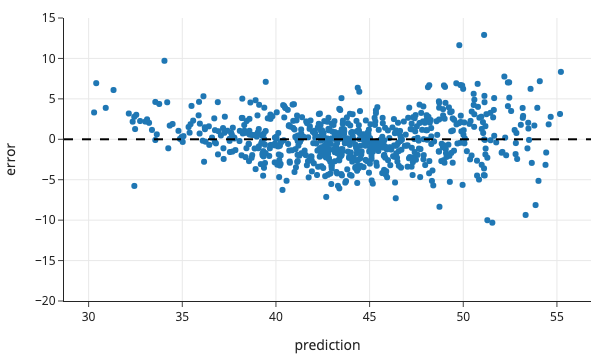

In [97]:
fig = px.scatter(x=prediction_ct_sm, y=error_ct_sm,
           labels=dict(x='prediction', y='error'),
           width=350, height=250)

fig.add_hline(0, line_width=2, line_dash='dash', opacity=1)
fig.update_yaxes(range=[-20, 15])

fig.show()

The larger variability in the errors for higher AUM is even more evident. The implications are that the estimates, $\hat{y}$, are unaffected, but their accuracy depends on AUM. This problem can be addressed with *weighted regression*.

:::{note}

Once again, we point out that data scientists from different backgrounds use
different terminology to refer to the same concept.
For example, the terminology that calls each row in the design matrix $\textbf{X}$ an observation and each column a variable is more common among people with backgrounds in statistics.
Others say that each column of the design matrix represents a *feature* or that each row represents a *record*.
Also, we say that our overall process of fitting and interpreting models
is called *modeling*, while others call it *machine learning*.

:::

Now, let's fit a multiple linear model that uses all seven variables to explain upward mobility. After fitting the model, we again plot the errors using the same $y$-axis scale as in the previous two residual plots: 

In [98]:
X7 = cz_df[predictors]
model_7var = LinearRegression().fit(X7, y)

prediction_7var = model_7var.predict(X7)
error_7var = y - prediction_7var

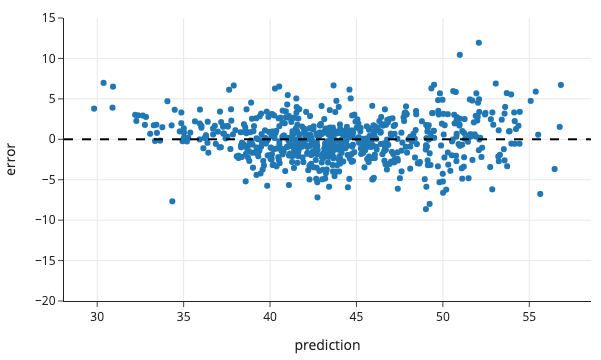

In [99]:
fig = px.scatter(x=prediction_7var, y=error_7var,
           labels=dict(x='prediction', y='error'),
           width=350, height=250)

fig.add_hline(0, line_width=2, line_dash='dash', opacity=1)
fig.update_yaxes(range=[-20, 15])

fig.show()

The model with seven features does not appear to be much better than the two-variable model. In fact, the standard deviation of the residuals has only decreased by 8\%:

In [100]:
error_7var.std() 

2.5887392335742567

We can compare the Multiple $R^2$ for these three models: 

In [102]:
print(f"R² for 7-variable model: {model_7var.score(X7, y):.2f}")
print(f"R² for 2-variable model: {model_ct_sm.score(X2, y):.2f}")
print(f"R² for 1-variable model: {model_ct.score(X, y):.2f}")

R² for 7-variable model: 0.79
R² for 2-variable model: 0.74
R² for 1-variable model: 0.46


The adjustment for the number of features in the model makes little difference for us since we have over 700 observations. Now, we have confirmed our earlier findings that two variables greatly improves the explanatory capability of the model, and the seven-variable model offers little improvement over the two-variable model. The small gain is likely not worth the added complexity of the model. 

So far, our models have used only numeric predictor variables.
But, categorical data is often useful for model fitting as well. Additionally, in {numref}`Chapter %s <ch:eda>` we transformed variables and created new variables from combinations of variables. We address how to incorporate these variables into linear models next.